In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# Import necessary libraries
import os
import sys

from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms

# Directory path used in Google Colab
# project_dir = '/content/drive/MyDrive/Colab Notebooks/HGCAL/visual-inspection'

# Directory path used in local
project_dir = '../'

current_dir = os.path.join(project_dir, 'autoencoder')
sys.path.append(current_dir)

from data_loading import *
from training import *

# Set the seed
torch.manual_seed(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Path to the datasets folder
DATASET_PATH = os.path.join(project_dir, 'datasets')
CHECKPOINT_PATH = os.path.join(current_dir, 'small_ae.pt')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device
print(CHECKPOINT_PATH)

../autoencoder\small_ae.pt


In [3]:
# Read in the image
image = Image.open(os.path.join(DATASET_PATH, 'unperturbed_data', 'good_hexaboard.png'))

# Get the height and width of the image
width, height = image.size
print('Image width:', width)
print('Image height:', height)

Image width: 1100
Image height: 943


In [4]:
# Adjust the number of segments
# THIS SHOULD WORK WITH THE GUI
NUM_VERTICAL_SEGMENTS = 20
NUM_HORIZONTAL_SEGMENTS = 12

# Define the transformations
transform = transforms.Compose([
    RotationAndSegmentationTransform(
        height=height,
        width=width,
        vertical_segments=NUM_VERTICAL_SEGMENTS,
        horizontal_segments=NUM_HORIZONTAL_SEGMENTS
    ),
    # transforms.RandomRotation(degrees=2),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomVerticalFlip(),
])

# Read in and process the iamges
train_dataset = HexaboardDataset(
    image_dir=os.path.join(DATASET_PATH, 'unperturbed_data'),
    transform=transform
)

# Set the batch and chunk size
batch_size = 1
chunk_size = 12

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

In [5]:
# # Save the segments to a folder to synthesize perturbed data
# data_iter = next(iter(train_loader)).squeeze(0)
# # print(data_iter.shape)

# for i, image in enumerate(data_iter):
#     image = image.squeeze(0).moveaxis(0,2).numpy() * 255
#     image = Image.fromarray(np.asarray(np.clip(image, 0, 255), dtype="uint8"))
#     image.save(os.path.join(DATASET_PATH, 'perturbed_data', f'bad_hexaboard_{i + 1}.png'))

In [6]:
# Function to remove the transparency channel
def remove_transparency(
    image_dir: str,
):
    image_paths = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.png')]

    for image_path in image_paths:
        img = Image.open(image_path)
        img = np.array(img)
        img = img[:, :, 0:3]
        img = Image.fromarray(img)
        img.save(image_path)

remove_transparency(os.path.join(DATASET_PATH, 'perturbed_data'))

In [7]:
# Adjust the number of segments
# THIS SHOULD WORK WITH THE GUI
NUM_VERTICAL_SEGMENTS = 20
NUM_HORIZONTAL_SEGMENTS = 12

# Define the transformations
transform = transforms.Compose([
    RotationAndSegmentationTransform(
        height=height,
        width=width,
        vertical_segments=NUM_VERTICAL_SEGMENTS,
        horizontal_segments=NUM_HORIZONTAL_SEGMENTS
    ),
    transforms.RandomRotation(degrees=2),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
])

# Read in and process the images
train_dataset = HexaboardDataset(
    image_dir=os.path.join(DATASET_PATH, 'unperturbed_data'),
    transform=transform
)
val_dataset = HexaboardDataset(
    image_dir=os.path.join(DATASET_PATH, 'perturbed_data'),
    transform=transforms.Compose([transforms.ToTensor()])
)

# Set the batch and chunk size
batch_size = 1
chunk_size = 12

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

# Print some information about the data
print(f'Train dataset size: {len(train_dataset)}')
print(f'Validation dataset size: {len(val_dataset)}')
# print(f'Test dataset size: {len(test_dataset)}')
print(f'Segments Shape: {val_dataset[0].shape}')
print(f'Image shape: {val_dataset[0][0].shape}')
print(f'Image tensor type: {train_dataset[0][0].dtype}')
print(f'Batches: {len(train_loader)}')

Train dataset size: 1
Validation dataset size: 6
Segments Shape: torch.Size([3, 47, 45])
Image shape: torch.Size([47, 45])
Image tensor type: torch.float32
Batches: 1


In [8]:
# Get the segments' height and width
segment_height = train_dataset[0][0][0].shape[0]
segment_width = train_dataset[0][0][0].shape[1]
print('Segment height:', segment_height)
print('Segment width:', segment_width)

Segment height: 47
Segment width: 45


In [14]:
# Initialize the model
cnn_ae = ConvAutoEncoder(
    in_channels=3,
    height=segment_height,
    width=segment_width,
    latent_dim=512,
    kernel_sizes=[128, 256]
)
cnn_ae.to(device)

ConvAutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU(inplace=True)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=28160, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=28160, bias=True)
  (unflatten): Unflatten(dim=1, unflattened_size=(256, 11, 10))
  (decoder): Sequential(
    (0): ConvTranspose2d(256, 256, kernel_size=(3, 3), stride=(2, 2), output_padding=(0, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(256, 3, kernel_size=(3, 3), stride=(2, 2))
  )
)

In [15]:
optimizer = optim.Adam(cnn_ae.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.925)
criterion = nn.BCEWithLogitsLoss()

# Train the model
history, cnn_ae = train_autoencoder(
    model=cnn_ae,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    scheduler=scheduler,
    num_epochs=25,
    save_path=CHECKPOINT_PATH
)

Epoch 1/25:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch [1/25], Train Loss: 0.5906, Val Loss: 0.6268, LR: [0.001]


Epoch 2/25:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch [2/25], Train Loss: 0.5353, Val Loss: 0.6200, LR: [0.000925]


Epoch 3/25:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch [3/25], Train Loss: 0.5294, Val Loss: 0.6140, LR: [0.000855625]


Epoch 4/25:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch [4/25], Train Loss: 0.5188, Val Loss: 0.6096, LR: [0.0007914531250000001]


Epoch 5/25:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch [5/25], Train Loss: 0.5085, Val Loss: 0.6013, LR: [0.0007320941406250001]


Epoch 6/25:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch [6/25], Train Loss: 0.5031, Val Loss: 0.5911, LR: [0.0006771870800781251]


Epoch 7/25:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch [7/25], Train Loss: 0.4995, Val Loss: 0.5814, LR: [0.0006263980490722658]


Epoch 8/25:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch [8/25], Train Loss: 0.4960, Val Loss: 0.5753, LR: [0.0005794181953918459]


Epoch 9/25:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch [9/25], Train Loss: 0.4937, Val Loss: 0.5695, LR: [0.0005359618307374575]


Epoch 10/25:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch [10/25], Train Loss: 0.4902, Val Loss: 0.5634, LR: [0.0004957646934321482]


Epoch 11/25:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch [11/25], Train Loss: 0.4885, Val Loss: 0.5589, LR: [0.0004585823414247371]


Epoch 12/25:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch [12/25], Train Loss: 0.4873, Val Loss: 0.5587, LR: [0.0004241886658178818]


Epoch 13/25:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch [13/25], Train Loss: 0.4855, Val Loss: 0.5562, LR: [0.0003923745158815407]


Epoch 14/25:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch [14/25], Train Loss: 0.4846, Val Loss: 0.5528, LR: [0.00036294642719042513]


Epoch 15/25:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch [15/25], Train Loss: 0.4836, Val Loss: 0.5499, LR: [0.00033572544515114326]


Epoch 16/25:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch [16/25], Train Loss: 0.4795, Val Loss: 0.5487, LR: [0.00031054603676480754]


Epoch 17/25:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch [17/25], Train Loss: 0.4821, Val Loss: 0.5480, LR: [0.000287255084007447]


Epoch 18/25:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch [18/25], Train Loss: 0.4795, Val Loss: 0.5471, LR: [0.0002657109527068885]


Epoch 19/25:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch [19/25], Train Loss: 0.4809, Val Loss: 0.5456, LR: [0.0002457826312538719]


Epoch 20/25:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch [20/25], Train Loss: 0.4802, Val Loss: 0.5438, LR: [0.0002273489339098315]


Epoch 21/25:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch [21/25], Train Loss: 0.4792, Val Loss: 0.5429, LR: [0.00021029776386659413]


Epoch 22/25:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch [22/25], Train Loss: 0.4790, Val Loss: 0.5420, LR: [0.00019452543157659957]


Epoch 23/25:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch [23/25], Train Loss: 0.4783, Val Loss: 0.5409, LR: [0.00017993602420835462]


Epoch 24/25:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch [24/25], Train Loss: 0.4778, Val Loss: 0.5398, LR: [0.00016644082239272804]


Epoch 25/25:   0%|          | 0/1 [00:00<?, ?batch/s]

Epoch [25/25], Train Loss: 0.4775, Val Loss: 0.5393, LR: [0.00015395776071327344]


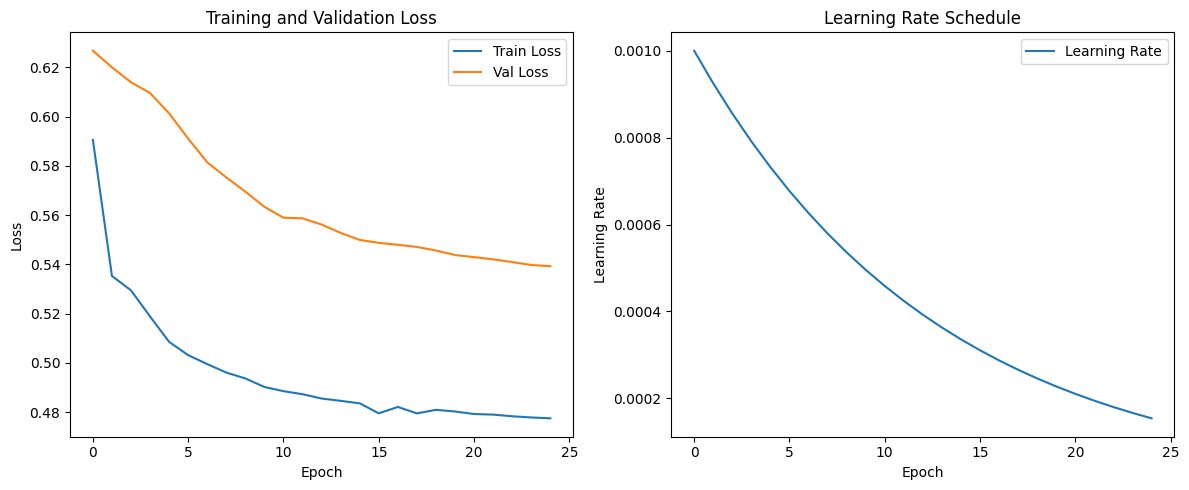

In [16]:
# View the training progress
plot_metrics(history)

In [12]:
# Load the model's weights
cnn_ae.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=device))

<All keys matched successfully>

Train Loss: 0.4751


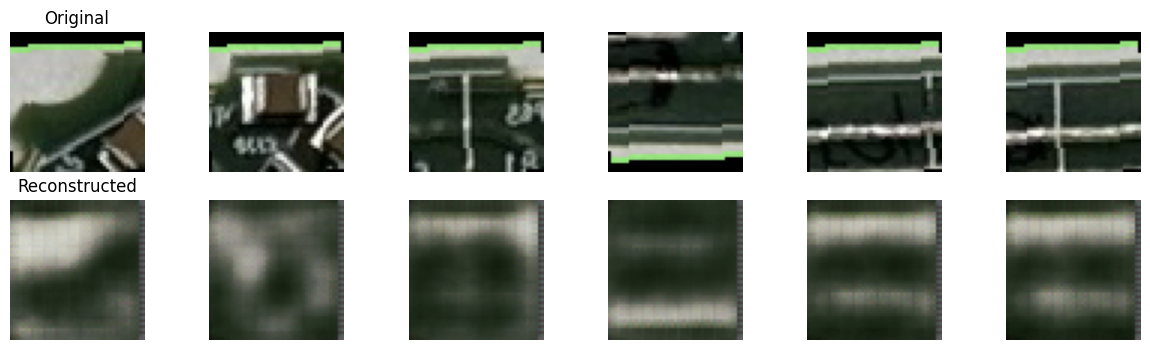

Test Loss: 0.5393


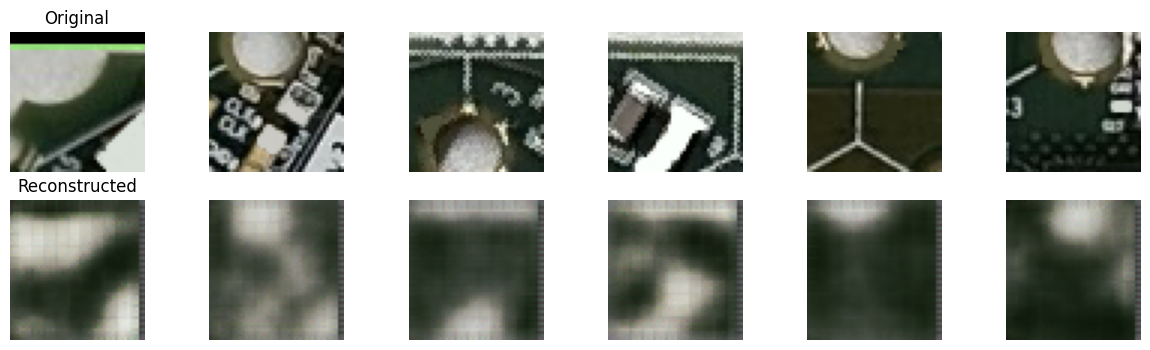

In [17]:
# Evaluate the model on unperturbed vs. perturbed images
criterion = nn.BCEWithLogitsLoss()

evaluate_autoencoder(
    model=cnn_ae,
    criterion=criterion,
    train_loader=train_loader,
    test_loader=val_loader,
    num_images=6,
    visualize=True
)